<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Task-description" data-toc-modified-id="Task-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Task description</a></span></li><li><span><a href="#Dataset-visualization" data-toc-modified-id="Dataset-visualization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dataset visualization</a></span></li><li><span><a href="#Generate-data-for-experiments" data-toc-modified-id="Generate-data-for-experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate data for experiments</a></span></li><li><span><a href="#RBF-RBF" data-toc-modified-id="RBF-RBF-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RBF-RBF</a></span></li><li><span><a href="#kerES" data-toc-modified-id="kerES-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>kerES</a></span></li><li><span><a href="#linSES" data-toc-modified-id="linSES-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>linSES</a></span></li></ul></div>

In [7]:
# # !pip install iisignature
# !pip install tslearn

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import torch
import pandas as pd
import importlib
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import utils_particles

import RBF_RBF
import RBF_GA
import RBF_Matern
import kerES
import KES
import linSES
import sklearn_transformers
import deep_sets


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pylab as pylab
ff = 20
params = {'legend.fontsize': ff,
          'figure.figsize': (16, 5),
          'axes.labelsize': ff,
          'axes.titlesize':ff,
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


# Task description

The goal is to infer the temperature $T$ of a simulated ideal gas from the trajectories traced by the $N$ particles that compose the gas. The particles evolve in a $3$-d box of fixed volume $V$. The training dataset corresponds to $M$ gases, and is in the form $\{(\{x^{i,j}\}_{j=1}^{N},T_i)\}_{i=1}^{M}$, where $T_i$ is the temperature (in Kelvin) of gas $i$, and $x^{i,j}$ is the $3$-d time-series corresponding to the particle $j$ of gas $i$. 

In this notebook we simulate $M=20$ gases subject to a temperature chosen at random $T\sim\mathcal{U}(1,1000)$. Each gas is composed by $N=20$ particles. We conduct too experiments: 
- **(low number of collisions)** the particles have a small radius $r=0.05\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/low_col_particles.obj)
- **(high number of collisions)** the particles have a bigger radius $r=0.35\cdot(V/N)^{1/3}$. (precomputed dataset: ./data/high_col_particles.obj)

This notebook contains the code to generate new datasets. Alternatively, 2 precomputed datasets can be loaded.

# Dataset visualization 

In [2]:
# gas properties
n_particles = 20
V = 3
r = 3.5e-1*(V/n_particles)**(1./3)
max_time = 2
dt = 0.005

# chose the range of temperatures 
temps = [1, 500, 1000]

# simulate gases subject to the temperatures defined above
gases_plot = []
for temp in temps:
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)

    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]

    gases_plot.append(trajectories)

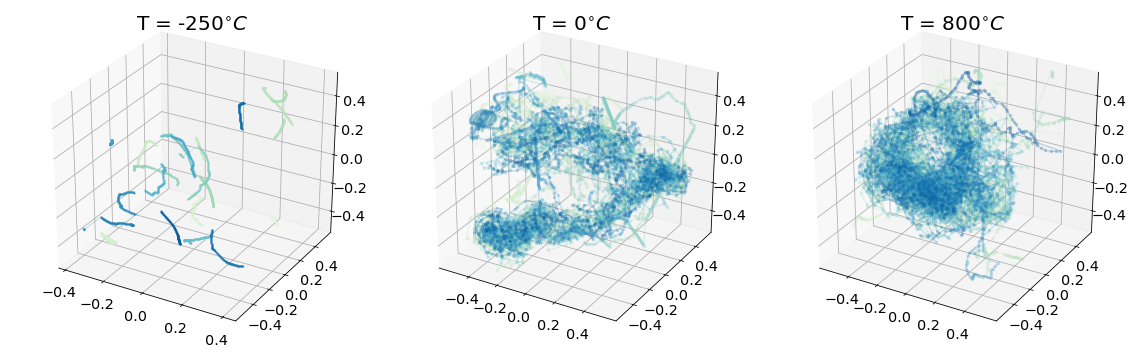

In [32]:
# plot
colors = plt.cm.GnBu(np.linspace(0.1,0.9,n_particles))
fig = plt.figure()

tt = [-250, 0, 800]

u = 0

for k in range(len(temps)):
    if u==0:
        ss = 1.
    else:
        ss = 2.5
    ax = fig.add_subplot(1, len(temps), k+1, projection='3d')
    for p in range(n_particles):
        ax.plot(gases_plot[k][p][:,0],gases_plot[k][p][:,1],gases_plot[k][p][:,2], alpha=0.2, color=colors[p], 
                marker='o', markersize=ss)
    temp_celsius = tt[k]#temps[k]-273
    ax.set_title(f'T = {temp_celsius}' + '$^{\circ}C$')
    u+=1
    
fig.tight_layout()
#plt.savefig('../pictures/ideal_gas.png')
plt.show()

# Generate data for experiments

**Properties of the gases**

In [10]:
# how many gases
np.random.seed(0)
M = 50

# parameters which do not change from one gas to another
n_particles = 20
V = 3
r = 3.5e-1*(V/n_particles)**(1./3)
max_time = 2
dt = 0.01


# temperatures of the M gases
max_T = 1000
min_T = 1
temperatures = np.array((max_T-min_T)*np.random.rand(M)+min_T)

**Simulate $M$ gases**

In [11]:
gases = []
for temp in tqdm(temperatures):
    
    Gas = utils_particles.Sim(n_particles, r, temp, V, max_time, dt)
    
    # To store the trajectories
    trajectories = [[] for i in range(n_particles)]

    for t in np.linspace(0, Gas.max_time, Gas.Nt):
        positions = Gas._draw_frame(t)
        for i in range(len(trajectories)):
            # update particle i
            trajectories[i].append(list(positions[i]))
    trajectories = [np.array(particle) for particle in trajectories]
    
    gases.append(trajectories)

100%|██████████| 50/50 [00:34<00:00,  1.47it/s]


In [4]:
def mse(results):
    mse_vec = np.zeros(len(results))
 
    for i in range(len(results)):
        pred = results[i]['pred']
        true = results[i]['true']
        mse_vec[i]=np.mean((pred-true)**2)
    return np.mean(mse_vec), np.std(mse_vec)

def mape(results):
    mape_vec = np.zeros(len(results))
 
    for i in range(len(results)):
        pred = results[i]['pred']
        true = results[i]['true']
        mape_vec[i]=np.mean(np.abs((true - pred) / true))*100 
    return np.mean(mape_vec), np.std(mape_vec)

# RBF-RBF

In [13]:
## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# max_T = 1000

m_mse, std_mse, results_RBF = RBF_RBF.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', NUM_TRIALS=5,  cv=3)


100%|██████████| 5/5 [00:35<00:00,  7.19s/it]


In [15]:
print('mse',mse(results_RBF))
print('mape',mape(results_RBF))

mse (0.030804794298223227, 0.00396214518496482)
mape (32.08641246830084, 5.78228414540356)


In [14]:
# plt.scatter(results_RBF[0]['pred'],results_RBF[0]['true'])
# plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

# RBF-Matern

In [16]:
## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# max_T = 1000

m_mse, std_mse, results_Matern = RBF_Matern.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', NUM_TRIALS=5,  cv=3)


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    3.1s finished


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    2.5s finished


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    2.6s finished


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    2.4s finished


Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    2.7s finished


In [17]:
print('mse',mse(results_Matern))
print('mape',mape(results_Matern))

mse (0.035490021062407284, 0.004811895286555011)
mape (33.796723659074246, 5.156262559227485)


# RBF-GA

In [18]:
## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# max_T = 1000

m_mse, std_mse, results_GA = RBF_GA.model(gases, temperatures/max_T, ll=[0,1,2], at=True, mode='krr', NUM_TRIALS=5,  cv=3)

In [19]:
print('mse',mse(results_GA))
print('mape',mape(results_GA))

mse (0.02848046147250303, 0.004261693226598358)
mape (31.60822305166328, 5.6017204182596645)


# kerES

In [21]:
# ## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# # gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# # max_T = 1000

# m_mse, std_mse, results = kerES.model(gases, temperatures/max_T,ll=[0,1,2],at=True, depths = [2,3,4], mode='krr', NUM_TRIALS=5,  cv=3)

# KES

In [22]:
## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# max_T = 1000

m_mse, std_mse, results_KES = KES.model(gases, temperatures/max_T,ll=[0,1,2],at=True, scales = [0.4], mode='krr', NUM_TRIALS=5,  cv=3)

  0%|          | 0/1 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   31.3s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:   54.0s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1275 out of 1275 | elapsed:  1.6min finished
 20%|██        | 1/5 [00:00<00:01,  3.58it/s]

best truncation level (cv on the train set):  0.4


 40%|████      | 2/5 [00:00<00:00,  3.58it/s]

best truncation level (cv on the train set):  0.4


 60%|██████    | 3/5 [00:00<00:00,  3.58it/s]

best truncation level (cv on the train set):  0.4


 80%|████████  | 4/5 [00:01<00:00,  3.57it/s]

best truncation level (cv on the train set):  0.4


100%|██████████| 5/5 [00:01<00:00,  3.56it/s]

best truncation level (cv on the train set):  0.4
scores [0.01047839 0.00933122 0.01334239 0.01912067 0.01314363]


In [23]:
print('mse',mse(results_KES))
print('mape',mape(results_KES))

mse (0.013083260046401254, 0.003387752471473074)
mape (16.56778188287719, 4.885888527798362)


# linSES

In [24]:
## loading a precomputed dataset (low_col_particles.obj or high_col_particles.obj)
# gases, temperatures = pickle.load(open('../data/high_col_particles.obj','rb'))
# max_T = 1000

m_mse, std_mse, results_SES  = linSES.model(gases, temperatures/max_T, ll=[0,1,2],at=True, depths1=[2,3], depth2=2,NUM_TRIALS=5, cv=3)

 20%|██        | 1/5 [00:35<02:20, 35.07s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [01:10<01:45, 35.12s/it]

best truncation level (cv on train set):  2


 60%|██████    | 3/5 [01:41<01:08, 34.02s/it]

best truncation level (cv on train set):  3


 80%|████████  | 4/5 [02:16<00:34, 34.38s/it]

best truncation level (cv on train set):  2


100%|██████████| 5/5 [02:53<00:00, 34.61s/it]

best truncation level (cv on train set):  3


In [25]:
print('mse',mse(results_SES))
print('mape',mape(results_SES))

mse (0.012686970916610177, 0.0022870491048878794)
mape (15.753614801936365, 2.6484909349646166)


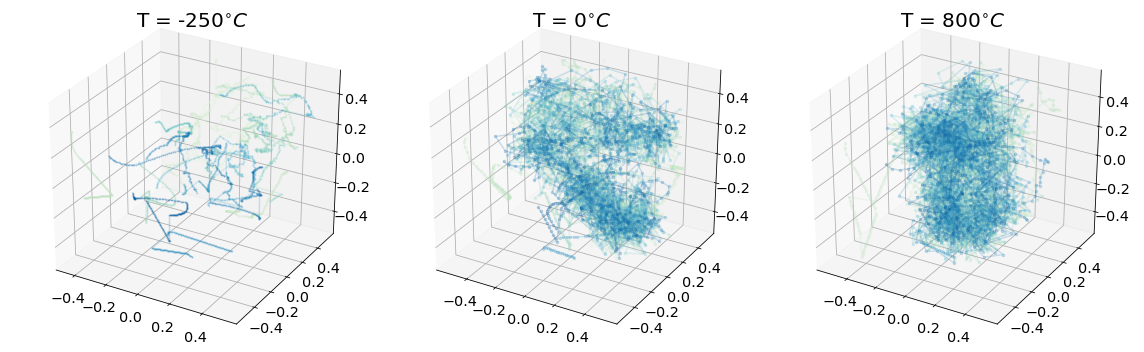

In [12]:
# plot
ind = np.ones(3,dtype=np.int)
ind[0] = int(np.argsort(temperatures)[0])
ind[1] = int(np.argsort(temperatures)[25])
ind[2] = int(np.argsort(temperatures)[-1])
colors = plt.cm.GnBu(np.linspace(0.1,0.9,n_particles))
fig = plt.figure()

tt = [-250, 0, 800]

u = 0

for k in range(len(ind)):
    if u==0:
        ss = 1.
    else:
        ss = 2.5
    ax = fig.add_subplot(1, len(ind), k+1, projection='3d')
    for p in range(n_particles):
        ax.plot(gases[ind[k]][p][:,0],gases[ind[k]][p][:,1],gases[ind[k]][p][:,2], alpha=0.2, color=colors[p], 
                marker='o', markersize=ss)
    temp_celsius = tt[k]#temps[k]-273
    ax.set_title(f'T = {temp_celsius}' + '$^{\circ}C$')
    u+=1
    
fig.tight_layout()
#plt.savefig('../pictures/ideal_gas.png')
plt.show()

In [26]:
results = {'rbf':results_RBF, 'Matern':results_Matern, 'GA':results_GA, 'KER':results_KES, 'SES':results_SES}

In [27]:
# import pickle
# pickle.dump(results,open('particles_3.5_50.obj','wb'))

In [28]:
results = pickle.load(open('particles_6.5_50.obj','rb'))

In [33]:
mse(results['GA'])

(0.03694222571048653, 0.003664203889378675)